:#**5.8.1: Sentiment analysis using GRU (PyTorch)**#

Sentiment analysis is a technique used in natural language processing to determine the polarity of a given text. There are several types of sentiment analysis, but one of the most generally used ways categorizes data as positive or negative. This aids in the study of various text elements, such as comments, tweets, and customer reviews, in order to understand the insights and feedbacks from the audience.

The new packages that are introduced in this example are as follows:
1. The Natural Language Toolkit (NLTK) is an open-source framework for developing applications that handle human language data. It includes robust text processing libraries for common Natural Language Processing (NLP) operations. For example, in the nltk.tokenize package, the word_tokenize method is used to split a text into smaller pieces known as tokens. These tokens may include sentences or individual words.
3. Regular Expression (RegEx) is a character sequence that defines a search pattern. The re package is a built-in Python package that is used to deal with RegEx. Hence it can be used to determine whether or not a string includes the given search pattern.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing packages**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In this example we are using the IMDB movie dataset.The dataset can be downloaded by clicking on this link: [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/). This dataset has 50,000 movie reviews for binary sentiment classification. Both training and testing have 25,000 movie reviews each that are labeled by sentiment (positive/negative) .  The dataset is used  to  estimate the amount of favorable and unfavorable reviews by applying Gated Recurrent Networks (GRU) for classification.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv('/content/drive/MyDrive/DL_Book_Notebooks/Ch4/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Here we create a bar plot of the class distributions to check for class imbalance. This helps to make sure if there are equal number of instances for each class so that it doesnot make the model skewed and less accurate.

**Visualizing the data**

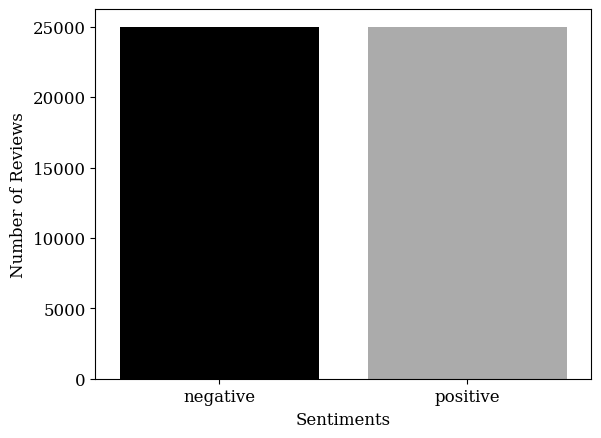

In [ ]:
class_counts = df['sentiment'].value_counts()
sns.set_palette(['#000000', '#ABABAB'])
sns.barplot(x=np.array(['negative','positive']),y=class_counts.values)
#plt.title('Class Distribution of Sentiments')
csfont = {'fontname':'serif'}
plt.xlabel('Sentiments',fontsize=12,**csfont)
plt.ylabel('Number of Reviews',fontsize=12,**csfont)
plt.xticks(fontsize=12,**csfont)
plt.yticks(fontsize=12,**csfont)
plt.savefig('Class.pdf',bbox_inches='tight')
plt.show()

**Data preprocessing**

The data preprocessing process entails eliminating any unnecessary information, addressing formatting problems, managing missing value, and fixing any mistakes in grammar or spelling errors. For the IMDB dataset this process has the following steps:
1. Removal of stopwords: Common terms like "the," "a," "an," etc. that appear often in a speech are known as stopwords. They are often eliminated from the text because they don't contribute any information to the analysis.
2. HTML Tag removal: Unstructured text often has a significant amount of background noise. HTML tags are usually one of these elements that don't significantly contribute to studying and interpreting text, thus it should be avoided.
3. Stemming: Stemming is a method for eliminating affixes from words to reveal their basic structure. For instance, the term bloat is the stem of the phrases bloating, bloats, and bloated. Porter's method for stemming is one of the popular stemming algorithms. More details about this algorithm can be found in the paper ["An algorithm for suffix stripping"](https://www.emerald.com/insight/content/doi/10.1108/00330330610681286/full/html?casa_token=AtV9TZBogG0AAAAA:PFGpnpqiFQW6l8LUG16t717S3ACxYt7H4HECw8swLQxB7azbb-ZAVuOIer4CRnj4xxC6yEfpYFP0fJf8l64KZjowj2cyjYWbCAcV9STA2JPip1vMcx9e). The PorterStemmer class in NLTK allows us to apply Porter Stemmer algorithms for the words we need to stem.
4. Lemmatization: As opposed to stemming, lemmatization applies a linguistic analysis to words by taking into account a language's whole vocabulary in addition to word reduction. Thus it considers  both words and their context within a phrase. After lemmatization, the result is referred to as a "lemma,".  For instance, the stemming of the word cries is cri, and its lemma is cry.
5. Tokenization: The text is divided into tokens or individual words during the tokenization process.



In [ ]:
# Clean the data
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text



Intialize a progress indicator for data processing in pandas using tqdm.

In [ ]:
%%time

tqdm.pandas()
df['cleaned_text'] = df['review'].progress_apply(clean_text)

  0%|          | 0/50000 [00:00<?, ?it/s]

CPU times: user 18min 37s, sys: 2min 11s, total: 20min 48s
Wall time: 21min 16s


**Tokenize the reviews**

The reviews are encoded into integers, where each unique word is automatically indexed. You will build an index mapping dictionary with lower indexes for the commonly recurring words. Here it is created using the Counter method from the Collections library.


In [ ]:
all_text2 = df['cleaned_text'].tolist()
all_text2 = ' '.join(all_text2)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)
print (count_words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
# create an index mapping dictionary and replace words in our reviews by integers.
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
print(vocab_to_int)
reviews_split = df['cleaned_text'].tolist()
reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print(reviews_int[0:3])

Counter({'movi': 103240, 'film': 95853, 'one': 55435, 'like': 45197, 'time': 31952, 'good': 30179, 'make': 30019, 'charact': 28347, 'see': 28235, 'get': 27963, 'watch': 27871, 'even': 25347, 'stori': 25272, 'would': 24599, 'realli': 23090, 'well': 21784, 'scene': 21434, 'look': 19945, 'show': 19912, 'much': 19316, 'end': 19091, 'bad': 18532, 'great': 18395, 'peopl': 18378, 'go': 18254, 'love': 18218, 'also': 17972, 'first': 17581, 'think': 17543, 'act': 17481, 'play': 17370, 'way': 17233, 'thing': 16508, 'made': 16151, 'could': 15563, 'know': 15168, 'say': 14989, 'seem': 14133, 'work': 13888, 'plot': 13798, 'actor': 13593, 'two': 13545, 'mani': 13484, 'seen': 13374, 'come': 13257, 'year': 13247, 'want': 13179, 'take': 13146, 'never': 12979, 'life': 12932, 'best': 12629, 'tri': 12532, 'littl': 12430, 'ever': 12030, 'man': 11940, 'better': 11455, 'give': 11411, 'still': 10932, 'find': 10777, 'perform': 10728, 'feel': 10352, 'part': 10335, 'use': 10227, 'someth': 10218, 'director': 10041,

**Encode the labels**

Since we just have two output labels,  we shall designate "positive" as 1 and "negative" as 0.



In [ ]:
labels_split = df['sentiment'].tolist()
encoded_labels = [1 if label =='positive' else 0 for label in labels_split]
encoded_labels = np.array(encoded_labels)

**Examine the length of reviews by plotting**



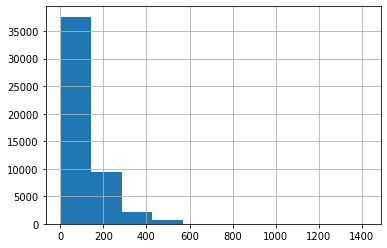

count    50000.000000
mean       118.119980
std         89.383593
min          3.000000
25%         63.000000
50%         88.000000
75%        144.000000
max       1416.000000
dtype: float64

In [ ]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

**Removing outliers**

Outliers are eliminated by removing unusually long or short reviews.

In [ ]:
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]


**Padding/Truncating the data**

As the length of each review varies, padding must be added (by adding 0) or words must be truncated to maintain the same size (mean of all reviews).

In [ ]:
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features

**Split the data into train, test and validation**

train= 80% | valid = 10% | test = 10%

In [ ]:
features = pad_features(reviews_int,200)
len_feat = len(features)
split_frac = 0.8

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]
train_y = np.array(train_y)
test_y = np.array(test_y)
valid_y = np.array(valid_y)

###**Tensor batching and loading**###

The dataset is represented as a list of tensors using the TensorDataset function. The Dataloader function loads the data into the model in batches during training, validation, and testing. The parameters in Dataloader function are as follows:
*  shuffle: This parameter shuffles the data between epochs so that the model does not learn the sequence of the data.
*	batch_size: This parameter defines the number of samples per batch that will be loaded into memory at a time.


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50
# dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)



###**Training the GRU**###

During the forward pass in training, the input is first passed through the embedding layer to obtain an embedded tensor, which is then fed into the GRU layer. To prevent overfitting, a dropout with a probability of 0.5 is applied to the output of the GRU layer. Finally, the resulting tensor is passed through a fully connected layer with a sigmoid activation function.

In [ ]:
class GRU(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_size, num_layers,drop_prob=0.5):
        super(GRU, self).__init__()

        self.output_size = output_size #size of the output tensor
        self.num_layers = num_layers #number of recurrent layers
        self.hidden_size = hidden_size #dimension of the hidden layer

        self.embedding = nn.Embedding(vocab_size, embedding_dim) #a layer that maps the input indices to their corresponding embedding vectors
        self.gru = nn.GRU(embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=drop_prob, batch_first=True) #the GRU layer
        self.dropout = nn.Dropout(p=0.5) #dropout layer with probability 0.5
        self.fc = nn.Linear(hidden_size, output_size) #fully connected layer
        self.sig = nn.Sigmoid() #activation function for binary classification

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        gru_out, h_out = self.gru(embeds, hidden)
        gru_out = gru_out.contiguous().view(-1, self.hidden_size)
        out = self.dropout(gru_out)
        out = self.fc(out)
        out = self.sig(out)
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, h_out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().cuda()
        return hidden




###**Check the available device**###

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print('GPU available')
else:
    device = torch.device("cpu")
    print('Only CPU')

GPU available


###**Instantiate the model with hyperparameters**###

In [ ]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_size = 256
num_layers = 2
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epochs = 10
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

net = GRU(vocab_size, output_size,embedding_dim, hidden_size, num_layers)
net.to(device)
print(net)

GRU(
  (embedding): Embedding(70959, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


###**Train the GRU model**###

In [ ]:
net.train()
for i in range(epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1
        h = h.data
        inputs, labels = inputs.to(device), labels.to(device)
        net.zero_grad()
        output, h = net(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if counter%print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inp, lab in valid_loader:
                val_h = val_h.data
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = net(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(net.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/2... Step: 500... Loss: 0.402970... Val Loss: 0.350252
Validation loss decreased (inf --> 0.350252).  Saving model ...
Epoch: 2/2... Step: 1000... Loss: 0.099800... Val Loss: 0.302027
Validation loss decreased (0.350252 --> 0.302027).  Saving model ...
Epoch: 2/2... Step: 1500... Loss: 0.168799... Val Loss: 0.310280


###**Testing the model**###

In [ ]:
# Loading the best model GRU
net.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = net.init_hidden(batch_size)

net.eval()
for inputs, labels in test_loader:
    h = h.data
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = net(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))


Test loss: 0.319
Test accuracy: 87.300%
